Exponential growth models comparison - stochastic vs deterministic

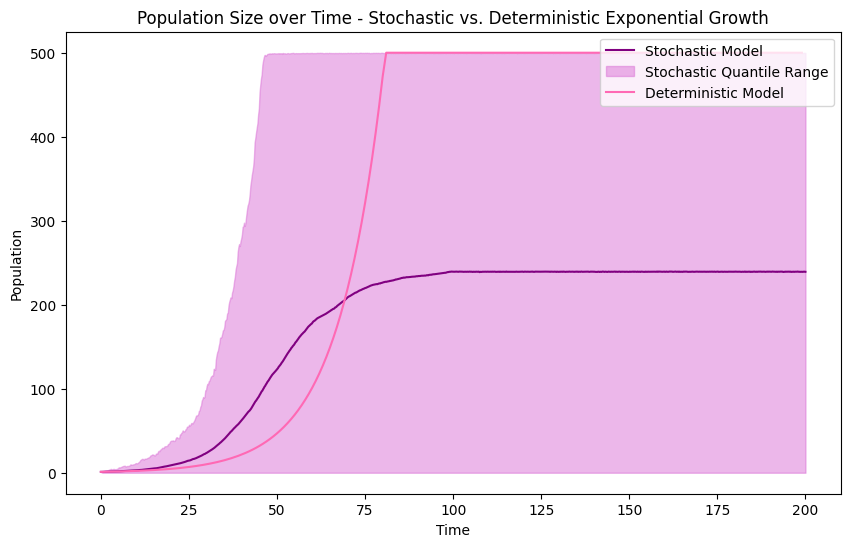

Stochastic Model Extinction Probability: 0.52


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Stochastic Exponential Model
def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.02, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    carrying_capacity = params['carrying_capacity']
    max_time = params['max_time']
    
    time_points = [0]
    population_sizes = [population]
    
    while population > 0 and time_points[-1] < max_time:
        next_event_time = np.random.exponential(1 / (death_rate * population + birth_rate * population))
        
        if np.random.rand() < birth_rate / (birth_rate + death_rate) and population < carrying_capacity:
            population += 1
        else:
            population -= 1
        
        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)
    
    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']
    
    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1

    # Interpolating population sizes
    num_points = 1000
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))
    
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.quantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.quantile(interpolated_populations, 0.95, axis=0)
    
    extinction_probability = extinction_count / num_simulations
    
    return average_time_points, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

# Deterministic Exponential Model
def exp_growth_model(b, d, K, P0, time_steps, dt):
    r = b - d  # growth rate
    population = np.zeros(time_steps)
    population[0] = P0

    for t in range(1, time_steps):
        P = population[t-1]
        dP = r * P
        population[t] = P + dP
        if population[t] >= K:
            population[t:] = K
            break

    return population

def plot_population_comparison(stochastic_time_points, avg_population, lower_quantile, upper_quantile, det_population, K, time_steps):
    plt.figure(figsize=(10, 6))
    plt.plot(stochastic_time_points, avg_population, color='purple', label='Stochastic Model')
    plt.fill_between(stochastic_time_points, lower_quantile, upper_quantile, color='orchid', alpha=0.5, label='Stochastic Quantile Range')
    plt.plot(range(time_steps), det_population, color='hotpink', label='Deterministic Model')
    
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Population Size over Time - Stochastic vs. Deterministic Exponential Growth')
    plt.legend(loc='upper right')
    plt.show()

# Run both models and plot the results
if __name__ == "__main__":
    # Stochastic Model Parameters and Simulation
    stochastic_params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1, carrying_capacity=500, max_time=200)
    num_simulations = 100
    avg_time_points, avg_population_sizes, lower_quantile, upper_quantile, extinction_prob = run_multiple_simulations_with_quantiles(stochastic_params, num_simulations)
    
    # Deterministic Model Parameters and Simulation
    b = 0.1  # birth rate
    d = 0.02  # death rate
    K = 500  # carrying capacity
    P0 = 1  # initial population
    time_steps = 200  # number of time steps
    dt = 1  # time step size

    det_population = exp_growth_model(b, d, K, P0, time_steps, dt)

    # Plot Comparison
    plot_population_comparison(avg_time_points, avg_population_sizes, lower_quantile, upper_quantile, det_population, K, time_steps)
    
    # Print Extinction Probability
    print(f"Stochastic Model Extinction Probability: {extinction_prob:.2f}")
